# UQPINNs

Satisfying the PDE constraint by simply minimizing the mean square loss on collocation points.
\begin{align}
    \mathcal{L}_{PDE}(\theta) = \frac{1}{N_r}\sum_{i=1}^{N_r}\|r_{\theta}(x_i, t_i)\|^2.
\end{align}
with
\begin{align}
	\mathcal{L}_{\mathcal{D}}(\psi) = & \  \mathbb{E}_{q(x,t)p(z)}[\log\sigma(T_{\psi}(x,t,f_{\theta}(x,t,z)))] + \\ & \ \mathbb{E}_{q(x,t,u)}[\log(1-\sigma(T_{\psi}(x,t,u)))],\\
	\mathcal{L}_{\mathcal{G}}(\theta, \phi) = & \ \mathbb{E}_{q(x,t)p(z)}[T_{\psi}(x, t, f_{\theta}(x,t,z))\\
	&+ (1-\lambda)\log(q_{\phi}(z|x,t,f_{\theta}(x,t,z)))],
\end{align}
Then, the resulting adversarial game for training the physics-informed model:
\begin{align}
    & \mathop{\max}_{\psi} \ \mathcal{L}_{\mathcal{D}}(\psi)\\
    & \mathop{\min}_{\theta, \phi} \ \mathcal{L}_{\mathcal{G}}(\theta, \phi) + \mathcal{L}_{PDE}(\theta),
\end{align}

In [2]:
# Define the model class

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import timeit

# Model class takes the intput:
# X_f: collocation points in [-1, 1], X_u: positions on the boundary (in this case -1 and 1), 
# Y_u: data on the boundary (in this case, boundary conditions), layers_P: network structure of generator,
# layers_Q: network structure of encoder, layers_T: network structure of discriminator,
# lam: entropic regularization coefficient, beta: physics-informed regularization

class ODE_UQPINN:
    # Initialize the class
    def __init__(self, X_f, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.0, beta = 1.0): 
        # X_f: collocation points, X_u: input data X, Y_u: output data Y,
        # layers_P: decoder network structure, layers_Q: encoder network structure, layers_T: discriminator network structure,
        # lam: entropic regularization parameter, beta: physics-informed regularization parameter
                
        # Normalize data
        self.Xmean = X_f.mean(0)
        self.Xstd = X_f.std(0)
        self.Ymean = Y_u.mean(0)
        self.Ystd = Y_u.std(0)
        X_f = (X_f - self.Xmean) / self.Xstd
        X_u = (X_u - self.Xmean) / self.Xstd
        # Jacobian with respect to the normalization
        self.Jacobian = 1 / self.Xstd
        
        # Normalized and collocation points and training input, output data
        self.X_f = X_f
        self.X_u = X_u
        self.Y_u = Y_u
        
        # Neural network structures
        self.layers_P = layers_P
        self.layers_Q = layers_Q
        self.layers_T = layers_T
        
        # Input, output and latent variable dimensions
        self.X_dim = X_u.shape[1]
        self.Y_dim = Y_u.shape[1]
        self.Z_dim = layers_Q[-1]
        
        # Regularization parameters
        self.lam = lam
        self.beta = beta

        # # material property
        # self.E = E
        # self.I = I
        
        # Ratio of training for generator and discriminator in each iteration: k1 for discriminator, k2 for generator
        self.k1 = 1
        self.k2 = 5

        # Initialize network weights and biases        
        self.weights_P, self.biases_P = self.initialize_NN(layers_P)
        self.weights_Q, self.biases_Q = self.initialize_NN(layers_Q)
        self.weights_T, self.biases_T = self.initialize_NN(layers_T)
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        
        # Define placeholders and computational graph
        self.X_u_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.X_f_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.Y_u_tf = tf.placeholder(tf.float32, shape=(None, self.Y_dim))
        self.Z_u_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))
        self.Z_f_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))

        # Predict output
        self.Y_u_pred = self.net_P(self.X_u_tf, self.Z_u_tf)
        # Predict the residual at collocation points
        self.Y_f_pred = self.get_r(self.X_f_tf, self.Z_f_tf)

        # Generator loss (to be minimized)
        self.G_loss, self.KL_loss, self.recon_loss, self.PDE_loss  = self.compute_generator_loss(self.X_u_tf, self.Y_u_tf, self.Y_u_pred,
                                                                        self.X_f_tf, self.Y_f_pred, self.Z_u_tf, self.Z_f_tf)
                                                
        # Discriminator loss (to be minimized)
        self.T_loss  = self.compute_discriminator_loss(self.X_u_tf, self.Y_u_tf, self.Z_u_tf)
        
        # Generate samples of y given x by sampling from latent space
        self.sample = self.sample_generator(self.X_u_tf, self.Z_u_tf)

        # Define optimizer        
        self.optimizer_KL = tf.train.AdamOptimizer(1e-4)
        self.optimizer_T = tf.train.AdamOptimizer(1e-4)
        
        # Define train Ops
        self.train_op_KL = self.optimizer_KL.minimize(self.G_loss, 
                                                      var_list = [self.weights_P, self.biases_P,
                                                                  self.weights_Q, self.biases_Q])
                                                                    
        self.train_op_T = self.optimizer_T.minimize(self.T_loss,
                                                    var_list = [self.weights_T, self.biases_T])

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
           
           
    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    # Forcing term (right hand of the ODE)
    def f(self, X_normalized): #
        X = self.Xstd * X_normalized + self.Xmean
        return 5*X
    
    # Decoder: p(y|x,z)
    def net_P(self, X, Z):
        Y = self.forward_pass(tf.concat([X, Z], 1),
                              self.layers_P,
                              self.weights_P,
                              self.biases_P)
        return Y
    
    # Encoder: q(z|x,y)
    def net_Q(self, X, Y):
        Z = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_Q,
                              self.weights_Q,
                              self.biases_Q)
        return Z
    
    # Discriminator
    def net_T(self, X, Y):
        T = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_T,
                              self.weights_T,
                              self.biases_T)        
        return T
    
    # Physics-Informed neural network prediction
    def get_u(self, X, Z):
        z_prior = Z       
        u = self.net_P(X, z_prior)
        return u

    # Physics-Informed residual on the collocation points
    def get_r(self, X, Z):
        z_prior = Z    
        u = self.net_P(X, z_prior)
        u_x = tf.gradients(u, X)[0]
        u_xx = tf.gradients(u_x, X)[0]
        f = self.f(X)
        r = (self.Jacobian ** 2) * u_xx + f
        return r    
    
    # Compute the generator loss
    def compute_generator_loss(self, X_u, Y_u, Y_u_pred, X_f, Y_f_pred, Z_u, Z_f):  
        # Prior: z_u for input data, z_f for collocation points
        z_u_prior = Z_u
        z_f_prior = Z_f
        # Encoder: q(z|x,y)
        z_u_encoder = self.net_Q(X_u, Y_u_pred)
        z_f_encoder = self.net_Q(X_f, Y_f_pred)
        # Discriminator loss
        Y_pred = self.net_P(X_u, Z_u)
        T_pred = self.net_T(X_u, Y_pred)
        
        # KL-divergence between the data distribution and the model distribution
        KL = tf.reduce_mean(T_pred)

        # Entropic regularization
        log_q = - tf.reduce_mean(tf.square(z_u_prior-z_u_encoder))
        
        # Physics-informed loss
        loss_f = tf.reduce_mean(tf.square(Y_f_pred))

        # Generator loss
        loss = KL + (1.0-self.lam)*log_q + self.beta * loss_f
        
        return loss, KL, (1.0-self.lam)*log_q, self.beta * loss_f
    
    # Compute the discriminator loss
    def compute_discriminator_loss(self, X, Y, Z): 
        # Prior: p(z)
        z_prior = Z
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)                
        
        # Discriminator loss
        T_real = self.net_T(X, Y)
        T_fake = self.net_T(X, Y_pred)
        
        T_real = tf.sigmoid(T_real)
        T_fake = tf.sigmoid(T_fake)
        
        T_loss = -tf.reduce_mean(tf.log(1.0 - T_real + 1e-8) + \
                                 tf.log(T_fake + 1e-8)) 
        
        return T_loss
           
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, Y, N_batch):
        N = X.shape[0]
        idx = np.random.choice(N, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
    
    
    # Trains the model
    def train(self, nIter = 20000, N_u = 2, N_f = 100): 

        start_time = timeit.default_timer()
        for it in range(nIter):     

            # Sampling from the latent space for data and collocation points
            Z_u = np.random.randn(N_u, self.Z_dim)
            Z_f = np.random.randn(N_f, self.Z_dim)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.X_u_tf: self.X_u, self.Y_u_tf: self.Y_u, self.X_f_tf: self.X_f,
                     self.Z_u_tf: Z_u, self.Z_f_tf: Z_f}  
            
            # Run the Tensorflow session to minimize the loss
            for i in range(self.k1):
                self.sess.run(self.train_op_T, tf_dict)
            for j in range(self.k2):
                self.sess.run(self.train_op_KL, tf_dict)
        
            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_KL_value, reconv, loss_PDE = self.sess.run([self.KL_loss, self.recon_loss, self.PDE_loss], tf_dict)
                loss_T_value = self.sess.run(self.T_loss, tf_dict)
                print('It: %d, KL_loss: %.2e, Recon_loss: %.2e, PDE_loss: %.2e, T_loss: %.2e, Time: %.2f' % 
                      (it, loss_KL_value, reconv, loss_PDE, loss_T_value, elapsed))
                start_time = timeit.default_timer()
                
    # Generate samples of y given x by sampling from the latent space z
    def sample_generator(self, X, Z):        
        # Prior:
        z_prior = Z       
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)      
        return Y_pred

    # Predict y given x
    def generate_sample(self, X_star):
        # Normalize the input data
        X_star = (X_star - self.Xmean) / self.Xstd
        Z = np.random.randn(X_star.shape[0], self.Z_dim)
        tf_dict = {self.X_u_tf: X_star, self.Z_u_tf: Z}       
        Y_star = self.sess.run(self.sample, tf_dict) 
        Y_star = Y_star 
        return Y_star

2024-12-10 10:59:32.814245: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 10:59:32.816078: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 10:59:32.911883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 10:59:33.196412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 10:59:33.933525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Implementation 

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt

import scipy.io
from plotting import newfig, savefig
import time
from scipy import stats

np.random.seed(1234)

In [5]:
print(tf.__version__)

2.16.1


In [6]:
# Number of collocation points
N_f = 100

# Number of testing points
N_ref = 200

# Number of the training data (in this example on the boundary)
N_u = 20

# Define the input, output, latent variable dimension
X_dim = 1
Y_dim = 1
Z_dim = 1


# material property
E = 2e7
I = 1e-6
sigma_E = 0.5e6

# Reference solution
def f(X,E,I):
    return -(50/(3*E*I))* X**3

# Position of the collocation points
X_f = np.linspace(0.,1.,N_f)[:,None]

# Position of the boundary conditions

# X_ut = np.linspace(0.,1.,3)[:,None]
point_1 = np.linspace(0., 0.5, 2)[:, None]
point_2 = np.linspace(0.6, 1, 8)[:, None]

# Correcting the concatenate function
X_ut = np.concatenate((point_1, point_2), axis=0)

print(X_ut)

X_u = X_ut
for i in range(N_u-1):
    X_u = np.vstack((X_u, X_ut))

print(np.size(X_u))

# Generate stochastic boundary condition
np.random.seed(42)  # Set random seed for reproducibility
E_samples = np.random.normal(E, sigma_E, 1)  # Sample E from normal distribution

Y_ut = f(X_ut,E_samples,I)
Y_u = Y_ut
for i in range(N_u-1):
    E_samples = np.random.normal(E, sigma_E, 1)  # Sample E from normal distribution
    Y_ut = f(X_ut,E_samples,I)
    Y_u = np.vstack((Y_u, Y_ut))

print(np.size(Y_u))

# Reference solution on the testing points
X_ref = np.linspace(0.,1.,N_ref)[:,None]
Y_ref = f(X_ref,E,I)

# # Load the reference solution of the stochastic ODE generated by Monte Carlo
# data = scipy.io.loadmat('./ODE2000.mat')
# Exact = np.real(data['U']).T


# # Define noise level
# noise_level = 0.05





# # Position of the collocation points
# X_f = np.linspace(0.,1.,N_f)[:,None]

# # Position of the boundary conditions
# # Monte Carlo sampling
# np.random.seed(42)  # Set random seed for reproducibility
# E_samples = np.random.normal(E, sigma_E, N_u)  # Sample E from normal distribution

# X_ut = np.linspace(0.,1.,N_f)[:,None]
# X_u = X_ut
# for i in range(N_u-1):
#     X_u = np.vstack((X_u, X_ut))

# print(np.size(X_u))


# # Compute deflection for each sample of E
# Y_u = np.array([f(X_ut, E, I) for E in E_samples])

# print(np.size(Y_u))

# # Generate stochastic boundary condition
# # Y_ut = f(X_ut)
# # Y_u = Y_ut
# # for i in range(N_u-1):
# #     Y_ut = noise_level * np.random.randn(2, Y_dim)
# #     Y_u = np.vstack((Y_u, Y_ut))

# # Reference solution on the testing points
# X_ref = np.linspace(0.,1.,N_ref)[:,None]
# Y_ref = f(X_ref,E,I)

# # # Load the reference solution of the stochastic ODE generated by Monte Carlo
# # data = scipy.io.loadmat('./ODE1000.mat')
# # Exact = np.real(data['w_samples']).T

[[0.        ]
 [0.5       ]
 [0.6       ]
 [0.65714286]
 [0.71428571]
 [0.77142857]
 [0.82857143]
 [0.88571429]
 [0.94285714]
 [1.        ]]
200
200


In [7]:
# Model creation
layers_P = np.array([X_dim+Z_dim,50,50,50,50,Y_dim])
layers_Q = np.array([X_dim+Y_dim,50,50,50,50,Z_dim])
layers_T = np.array([X_dim+Y_dim,50,50,1])

# Define the model
model = ODE_UQPINN(X_f, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.5, beta = 1.)

Device mapping: no known devices.


2024-12-10 10:59:36.968382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-10 10:59:36.969299: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


random_normal/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
random_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
random_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
random_normal_1/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
random_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
random_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
mul_1: (Mul): /

2024-12-10 10:59:37.382358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-10 10:59:37.386932: I tensorflow/core/common_runtime/placer.cc:125] random_normal/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-10 10:59:37.386943: I tensorflow/core/common_runtime/placer.cc:125] random_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-10 10:59:37.386947: I tensorflow/core/common_runtime/placer.cc:125] random_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-10 10:59:37.386950: I tensorflow/core/common_runtime/placer.cc:125] mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-10 10:59:37.386952: I tensorflow/core/common_runtime/placer.cc:125] Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-10 10:59:37.386956: I tensorflow/core/common_runtime/placer.cc:125] Variable/Assign: (Assign): /job:localhos

In [8]:
# Train the model
model.train(nIter = 30000, N_u = 10*N_u, N_f = N_f)

It: 0, KL_loss: 2.43e-02, Recon_loss: 4.50e-01, PDE_loss: 6.24e+00, T_loss: 1.32e+00, Time: 0.27
It: 100, KL_loss: 7.56e-01, Recon_loss: 2.60e-02, PDE_loss: 2.40e-01, T_loss: 8.73e-01, Time: 1.59
It: 200, KL_loss: -1.38e+00, Recon_loss: 7.49e-02, PDE_loss: 1.42e-01, T_loss: 2.22e+00, Time: 1.54
It: 300, KL_loss: 4.90e-01, Recon_loss: 3.20e-02, PDE_loss: 2.03e-02, T_loss: 1.23e+00, Time: 1.45
It: 400, KL_loss: 1.50e-02, Recon_loss: 1.29e-02, PDE_loss: 4.10e-03, T_loss: 1.36e+00, Time: 1.50
It: 500, KL_loss: -2.72e-01, Recon_loss: 1.23e-02, PDE_loss: 1.42e-02, T_loss: 1.49e+00, Time: 1.56
It: 600, KL_loss: -4.79e-02, Recon_loss: 2.93e-03, PDE_loss: 3.75e-03, T_loss: 1.40e+00, Time: 1.53
It: 700, KL_loss: -2.29e-02, Recon_loss: 6.63e-03, PDE_loss: 5.70e-03, T_loss: 1.38e+00, Time: 1.55
It: 800, KL_loss: 2.72e-02, Recon_loss: 2.03e-03, PDE_loss: 1.84e-03, T_loss: 1.35e+00, Time: 1.53
It: 900, KL_loss: 1.18e-02, Recon_loss: 2.27e-03, PDE_loss: 2.74e-03, T_loss: 1.38e+00, Time: 1.49
It: 1000

In [13]:
# Prediction

# Make prediciton at randomly chosen points X_ff (black lines are generated samples, red stars are predicted mean)
plt.figure(1)
N_samples = 2000
samples_mean = np.zeros((X_ref.shape[0], N_samples))
for i in range(0, N_samples):
    samples_mean[:,i:i+1] = model.generate_sample(X_ref)

# Compute the mean and the variance of the prediction at randomly selected points in the domain
mu_pred = np.mean(samples_mean, axis = 1)    
Sigma_pred = np.var(samples_mean, axis = 1)


<Figure size 640x480 with 0 Axes>

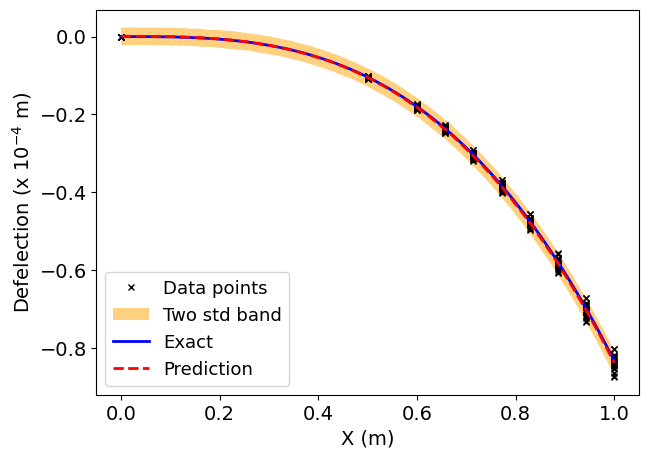

In [15]:
# Plot the prediction with the uncertainty versus the reference solution

ax = plt.figure(2,figsize=(7,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(X_u, Y_u, 'kx', markersize = 4, label = "Data points")
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                  facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('X (m)',fontsize=14)
plt.ylabel('Defelection (x $10^{-4}$ m)',fontsize=14)
plt.legend(loc='lower left', frameon=True, prop={'size': 13})
# Save the figure as a PNG file
plt.savefig('UQ_with_GAN4.png', dpi=300)
plt.show()

In [11]:
# Compute the prediction relative error 

mu_pred = mu_pred[:,None]
error_u = np.linalg.norm(Y_ref-mu_pred,2)/np.linalg.norm(Y_ref,2)
print('Error u: %e' % (error_u))  

Error u: 7.561304e-03
